In [98]:
import os
import glob

import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import f

import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.weightstats import ttest_ind

from pymer4.models.lmer import lmer
from pymer4.models.glmer import glmer

# Helper functions

In [99]:
def read_data_from_dir(dir=None):
    '''
    Read CSV files in dir as Pandas DataFrames.
    Annotate each sample read with an ID and.
    Concatenate all the DataFrames and annotate
    FrameSize for this big dataset.

    Input:
    dir: Directory containing CSV files for a particular cell size.
    '''
    df_list = []
    csv_files = glob.glob(os.path.sep.join([dir, '*']))

    i = 1
    for csv_file in csv_files:
        df_list.append(pd.read_csv(csv_file)[['cx', 'cy', 'area_mm2']].drop_duplicates())
        df_list[i - 1]['Sample'] = i
        i += 1
    
    df = pd.concat(df_list)
    df['FrameSize'] = 'S=' + dir.split(os.path.sep)[-1].split('_')[-1].replace('o', '.')
    df['FrameSize_x'] = float(dir.split(os.path.sep)[-1].split('_')[-1].replace('o', '.'))

    return df

def read_all_data_from_dir(dir=None):
    '''
    Read all data for all sizes and concatenate
    all of this data into one single DataFrame

    Input:
    dir: Parent directory containing data directories for each cell size.
    '''
    df_list = []
    data_dirs = glob.glob(os.path.sep.join([dir, '*']))

    for data_dir in data_dirs:
        df_list.append(read_data_from_dir(data_dir))
    
    df = pd.concat(df_list).sort_values(['FrameSize'])
    
    df['NormalizedCellSize'] = df.area_mm2 / df[df.FrameSize == 'S=1'].area_mm2.mean()
    df['FrameSize_num'] = df['FrameSize'].astype('category').cat.codes

    return df

def read_angle_data_from_dir(dir=None):
    '''
    Read angle data for from dir and cocatenate
    all of this data into one single DataFrame

    Input:
    dir: Directory containing all the angle files.
    '''
    df_list = []
    csv_files = glob.glob(os.path.sep.join([dir, '*single_cell_tilts.csv']))

    i = 1
    for csv_file in sorted(csv_files):
        df_list.append(pd.read_csv(csv_file)[['AngleOfTilt']].drop_duplicates())
        df_list[i - 1]['FrameSize'] = 'S=' + csv_file.split(os.path.sep)[-1].split('_')[0][:-1].replace('o', '.')
        df_list[i - 1]['FrameSize_x'] = float(csv_file.split(os.path.sep)[-1].split('_')[0][:-1].replace('o', '.'))
        i += 1

    df = pd.concat(df_list)
    df['FrameSize_num'] = df['FrameSize'].astype('category').cat.codes
        
    return df

# Statistical analysis

## Read cell size data

In [100]:
df = read_all_data_from_dir('../input/cell_size_data/cell_size_data')
df.loc[df.FrameSize == 'S=.75', 'FrameSize'] = 'S=0.75'

In [101]:
# First let's see how many samples are present for each construction mode
df.groupby('FrameSize')['NormalizedCellSize'].size()

FrameSize
S=0.75    2178
S=1       1364
S=1.25     688
S=1.5     1369
S=1.75     706
S=2        986
S=3        982
Name: NormalizedCellSize, dtype: int64

In [102]:
# Show the number of replicates for each construction mode and the number of samples per replicate
df.groupby(['FrameSize', 'Sample'])['NormalizedCellSize'].size()

FrameSize  Sample
S=0.75     1         401
           2         300
           3         704
           4         773
S=1        1         425
           2         279
           3          96
           4         564
S=1.25     1         117
           2         136
           3         435
S=1.5      1         325
           2         140
           3         381
           4         523
S=1.75     1         302
           2         166
           3         140
           4          98
S=2        1         237
           2         427
           3         322
S=3        1         551
           2          71
           3         360
Name: NormalizedCellSize, dtype: int64

## Create a color palette to use with plotting functions

In [103]:
i = 0
colors = list(mcolors.TABLEAU_COLORS.values())
color_dict = {}

for framesize in df.FrameSize.sort_values().unique():
    color_dict[str(framesize)] = colors[i]
    i += 1

## o75x covered cell proportion

In [104]:
# Read covered cells data
o75_covered_cells_df = pd.concat([pd.read_csv(csv_file).assign(Sample=i+1) for i, csv_file in enumerate(glob.glob('../input/o75-covered-cells-data/*'))])

In [105]:
# Data statistics
o75_covered_cells_df.groupby(['Sample'])[['covered', 'all']].sum()

,covered,all
Sample,,
1,65,272
2,82,338
3,115,480


### Compute covered cell proportion for each S=0.75 replicate and the overall covered cell proportion

In [106]:
for i in range(1, 4):
    print(f'Technical replicate {i}:')
    # 95% CI for proportion
    lower, upper = sm.stats.proportion_confint(o75_covered_cells_df[o75_covered_cells_df.Sample == i].covered.sum(), o75_covered_cells_df[o75_covered_cells_df.Sample == i]['all'].sum(), alpha=0.05)
    print(f'Proportion = {o75_covered_cells_df[o75_covered_cells_df.Sample == i].covered.sum() / o75_covered_cells_df[o75_covered_cells_df.Sample == i]["all"].sum()}')
    print(f'CI: [{lower}, {upper}]')

    # One-sample two-tailed z-test for proportion, h_0 = 0.25
    z_stat, p_value = proportions_ztest(count=o75_covered_cells_df[o75_covered_cells_df.Sample == i].covered.sum(), nobs=o75_covered_cells_df[o75_covered_cells_df.Sample == i]['all'].sum(), value=0.25, alternative='two-sided')
    print(f"Z-statistic: {z_stat}")
    print(f"P-value: {p_value}")
    print()

# 95% CI for proportion
print('Overall:')
lower, upper = sm.stats.proportion_confint(o75_covered_cells_df.covered.sum(), o75_covered_cells_df['all'].sum(), alpha=0.05)
print(f'Proportion = {o75_covered_cells_df.covered.sum() / o75_covered_cells_df["all"].sum()}')
print(f'CI: [{lower}, {upper}]')

# One-sample two-tailed z-test for proportion, h_0 = 0.25
z_stat, p_value = proportions_ztest(count=o75_covered_cells_df.covered.sum(), nobs=o75_covered_cells_df['all'].sum(), value=0.25, alternative='two-sided')
print(f"Z-statistic: {z_stat}")
print(f"P-value: {p_value}")

Technical replicate 1:
Proportion = 0.23897058823529413
CI: [0.18829059059167896, 0.2896505858789093]
Z-statistic: -0.4265440180463246
P-value: 0.669711480359427

Technical replicate 2:
Proportion = 0.24260355029585798
CI: [0.19690526028619432, 0.28830184030552164]
Z-statistic: -0.31722795383623154
P-value: 0.7510706403875927

Technical replicate 3:
Proportion = 0.23958333333333334
CI: [0.20139931873797612, 0.27776734792869057]
Z-statistic: -0.5346816389523369
P-value: 0.5928700201131578

Overall:
Proportion = 0.24036697247706423
CI: [0.21499967754993726, 0.2657342674041912]
Z-statistic: -0.744280659852585
P-value: 0.45670669914631123


#### Using mixed models

In [107]:
# Create records for cell level observation of covered cells
o75_covered_cells_records = []

for idx, data in o75_covered_cells_df.groupby(['Sample'])[['covered', 'all']].sum().iterrows():
    o75_covered_cells_records.extend([(idx, 1)] * data.covered)
    o75_covered_cells_records.extend([(idx, 0)] * (data['all'] - data.covered))

# Create DataFrame from records
o75_covered_cells_cell_level_pd_df = pd.DataFrame.from_records(
    data=o75_covered_cells_records,
    columns=['Sample', 'Covered']
)

o75_covered_cells_cell_level_pd_df['Sample'] = o75_covered_cells_cell_level_pd_df['Sample'].astype('category')
o75_covered_cells_cell_level_df = pl.DataFrame(o75_covered_cells_cell_level_pd_df)

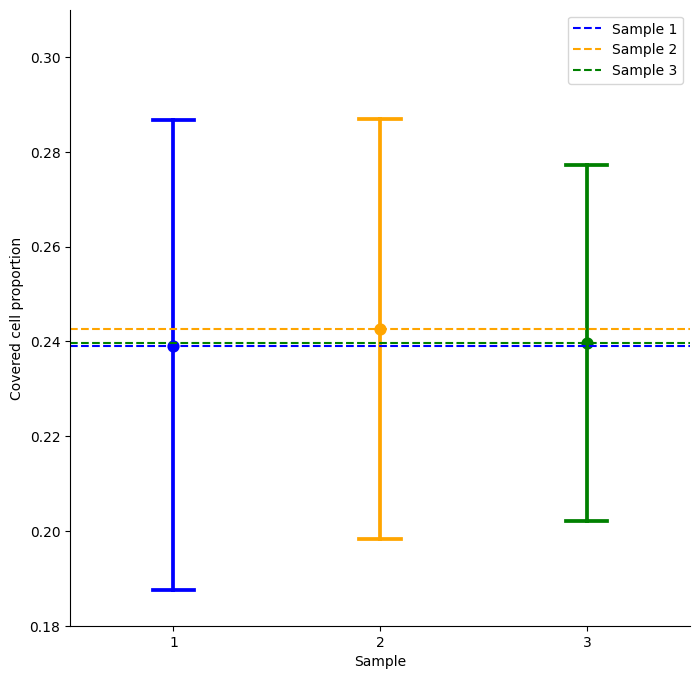

In [108]:
# Plot the data in each replicate
fig, axes = plt.subplots(figsize=(8, 8))

sns.pointplot(
    data=o75_covered_cells_cell_level_pd_df,
    x='Sample',
    y='Covered',
    color='0.1',
    capsize=0.2,
    linestyle='',
    hue='Sample',
    palette={
        1: 'blue',
        2: 'orange',
        3: 'green',
    },
    legend=False,
    ax=axes,
)

axes.axhline(
    y=o75_covered_cells_cell_level_pd_df[o75_covered_cells_cell_level_pd_df.Sample == 1].Covered.mean(),
    # xmin=0.125,
    # xmax=0.375,
    linestyle='--',
    color='blue',
    label='Sample 1',
)
axes.axhline(
    y=o75_covered_cells_cell_level_pd_df[o75_covered_cells_cell_level_pd_df.Sample == 2].Covered.mean(),
    # xmin=0.375,
    # xmax=0.625,
    linestyle='--',
    color='orange',
    label='Sample 2',
)
axes.axhline(
    y=o75_covered_cells_cell_level_pd_df[o75_covered_cells_cell_level_pd_df.Sample == 3].Covered.mean(),
    # xmin=0.625,
    # xmax=0.875,
    linestyle='--',
    color='green',
    label='Sample 3',
)

axes.set_xlim([-0.5, 2.5])
axes.set_ylim([0.18, 0.31])
axes.set_xlabel('Sample')
axes.set_ylabel('Covered cell proportion')

axes.set_xticks([0, 1, 2], [1, 2, 3])

sns.despine()
plt.legend()

In [109]:
# Fit the logistic mixed model
model = glmer('Covered ~ 1 + (1|Sample)', data=o75_covered_cells_cell_level_df, family="binomial")
result = model.fit(summary=True)

# Extract the fixed effect (log-odds) and derive the covered cell proportion
mu_hat = model.params.row(by_predicate=(pl.col('term') == '(Intercept)'))[1]
mu_ci_low = model.result_fit.row(by_predicate=(pl.col('term') == '(Intercept)'))[3]
mu_ci_high = model.result_fit.row(by_predicate=(pl.col('term') == '(Intercept)'))[4]
p_hat = 1 / (1 + np.exp(-mu_hat))
p_hat_low = 1 / (1 + np.exp(-mu_ci_low))
p_hat_high = 1 / (1 + np.exp(-mu_ci_high))
print(f'Estimated proportion of covered cells: {p_hat:.3f} [{p_hat_low:3f}, {p_hat_high:3f}]')

result

R messages: 
boundary (singular) fit: see help('isSingular')

R messages: 
boundary (singular) fit: see help('isSingular')

R messages: 
boundary (singular) fit: see help('isSingular')

Estimated proportion of covered cells: 0.240 [0.215921, 0.266640]


GT(_tbl_data=shape: (4, 10)
┌────────────────┬─────────────┬───────────┬───────────┬───┬────────────┬──────┬─────────┬───────┐
│ rfx            ┆ param       ┆ estimate  ┆ conf_low  ┆ … ┆ z_stat     ┆ df   ┆ p_value ┆ stars │
│ ---            ┆ ---         ┆ ---       ┆ ---       ┆   ┆ ---        ┆ ---  ┆ ---     ┆ ---   │
│ str            ┆ str         ┆ f64       ┆ f64       ┆   ┆ f64        ┆ f64  ┆ str     ┆ str   │
╞════════════════╪═════════════╪═══════════╪═══════════╪═══╪════════════╪══════╪═════════╪═══════╡
│ Sample-sd      ┆ (Intercept) ┆ 0.0       ┆ null      ┆ … ┆ null       ┆ null ┆ null    ┆ null  │
│ null           ┆ null        ┆ null      ┆ null      ┆ … ┆ null       ┆ null ┆ null    ┆ null  │
│ Fixed Effects: ┆ null        ┆ null      ┆ null      ┆ … ┆ null       ┆ null ┆ null    ┆ null  │
│ null           ┆ (Intercept) ┆ -1.150669 ┆ -1.289598 ┆ … ┆ -16.233228 ┆ inf  ┆ <.001   ┆ ***   │
└────────────────┴─────────────┴───────────┴───────────┴───┴────────────┴──────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x7feb6628c880>, _boxhead=Boxhead([ColInfo(var='rfx', type=<ColInfoTypeEnum.default: 1>, column_label='Random Effects:', column_align='left', column_width=None), ColInfo(var='param', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_label='CI-low', column_align='right', column_width=None), ColInfo(var='conf_high', type=<ColInfoTypeEnum.default: 1>, column_label='CI-high', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='z_stat', type=<ColInfoTypeEnum.default: 1>, column_label='Z-stat', column_align='right', column_width=None), ColInfo(var='df', type=<ColInfoTypeEnum.default: 1>, column_label='df', column_align='right', column_width=None), ColInfo(var='p_value', type=<ColInfoTypeEnum.default: 1>, column_label='p', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7feb6628dd80>, _spanners=Spanners([]), _heading=Heading(title='Formula: glmer(Covered~1+(1|Sample))', subtitle=Md(text='Family: *binomial (link: *default*)*  \n            Number of observations: *1090*  \n            Confidence intervals: *parametric*  \n            ---------------------  \n            Log-likelihood: *-601*  \n            AIC: *1206* | BIC: *1216*  \n            Residual error: *1.0*  \n        '), preheader=None), _stubhead=None, _source_notes=[Md(text='Signif. codes: *0 *** 0.001 ** 0.01 * 0.05 . 0.1*')], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns=['param'], rows=None, mask=None), grpname=None, colname='param', rownum=0, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=['param'], rows=None, mask=None), grpname=None, colname='param', rownum=1, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=['param'], rows=None, mask=None), grpname=None, colname='param', rownum=2, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=['param'], rows=None, mask=None), grpname=None, colname='param', rownum=3, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=N

In [110]:
model.report()

We fitted a constant (intercept-only) logistic mixed model (estimated using ML
and Nelder-Mead optimizer) to predict Covered (formula: Covered ~ 1). The model
included Sample as random effect (formula: ~1 | Sample). The model's intercept
is at -1.15 (95% CI [-1.29, -1.01], p < .001).

Standardized parameters were obtained by fitting the model on a standardized
version of the dataset. 95% Confidence Intervals (CIs) and p-values were
computed using a Wald z-distribution approximation.



We only have three replicates (frames) and the model is unable to reliably estimate the random-effect variance across frames, resulting in a `singular fit` error. Moreover, the proportion of covered cells across frames is very similar, leading to a near zero variance for the random-effect in our model, suggesting that a simpler fixed-effect model might be sufficient to describe our data.

## o75x vs. 1x cell sizes

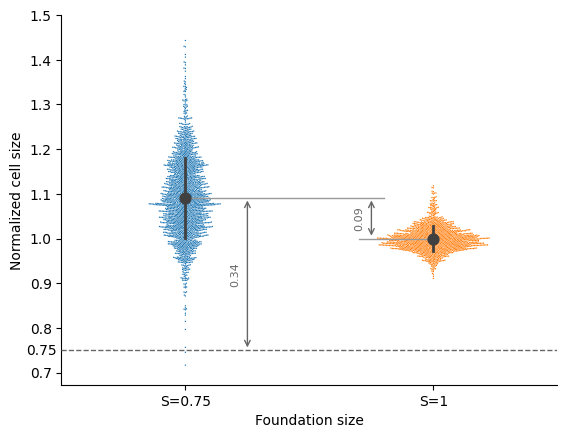

In [111]:
# Plot the cell size distributions and Mean + std. dev.
fig, axes = plt.subplots()

sns.swarmplot(data=df[df.FrameSize.isin(['S=0.75', 'S=1'])],
              x='FrameSize',
              y='NormalizedCellSize',
            #   alpha=0.5,
              palette=[color_dict[color] for color in ['S=0.75', 'S=1']],
              order=['S=0.75', 'S=1'],
              s=1,
              ax=axes,
              hue='FrameSize',
              legend=True,
              )
sns.pointplot(data=df[df.FrameSize.isin(['S=0.75', 'S=1'])],
              x='FrameSize',
              y='NormalizedCellSize',
              capsize=0,
              color='0.25',
              ax=axes,
              linestyles='',
              zorder=20,
              errorbar='sd',
              err_kws={'linewidth': 2},  # Error bar linewidth
              )

ymean_o75 = df[df.FrameSize == 'S=0.75']['NormalizedCellSize'].mean()
ymean_1 = df[df.FrameSize == 'S=1']['NormalizedCellSize'].mean()

axes.axhline(y=0.75, linestyle='--', linewidth=1, color='0.4', zorder=10)

axes.axhline(y=ymean_o75, xmin=0.25, xmax=0.65, linestyle='-', linewidth=1, color='0.6', zorder=10)
axes.axhline(y=ymean_1, xmin=0.6, xmax=0.75, linestyle='-', linewidth=1, color='0.6', zorder=10)

plt.annotate(
    '',  # Annotation text (distance)
    xy=(0.75, ymean_o75),  # Starting position
    xytext=(0.75, ymean_1),  # Offset for the text
    arrowprops=dict(arrowstyle='<->', color='0.4', lw=1),  # Bidirectional arrow
    ha='center',
    va='center',
)

# Add text for the distance
plt.text(
    x=0.7,
    y=(ymean_o75 + ymean_1) / 2,  # Place the text midway between the lines
    s=f'{(ymean_o75-ymean_1):.2f}', 
    ha='center', 
    va='center', 
    fontsize=8, 
    color='0.4',
    rotation='vertical',
)

plt.annotate(
    '',  # Annotation text (distance)
    xy=(0.25, ymean_o75),  # Starting position
    xytext=(0.25, 0.75),  # Offset for the text
    arrowprops=dict(arrowstyle='<->', color='0.4', lw=1),  # Bidirectional arrow
    ha='center',
    va='center',
)

# Add text for the distance
plt.text(
    x=0.2,
    y=(ymean_o75 + 0.75) / 2,  # Place the text midway between the lines
    s=f'{(ymean_o75-0.75):.2f}', 
    ha='center', 
    va='center', 
    fontsize=8, 
    color='0.4',
    rotation='vertical',
)

# Annotate the y-values on the y-axis
plt.text(
    x=plt.gca().get_xlim()[0] - 0.02,  # Slightly to the left of the y-axis
    y=0.75, 
    s=f'{0.75}', 
    va='center', 
    ha='right', 
    color='0.0', 
    fontsize=10
)

axes.set_ylabel('Normalized cell size')
axes.set_xlabel('Foundation size')

axes.set_ylim(top=1.5)

sns.despine()
axes.get_legend().remove()

fig.savefig('../output/figures/o75-vs-1-cell-size.png', dpi=600)
# plt.legend(title='Foundation size', markerscale=7)

### Mean normalized cell size per replicate and all data pooled

#### S=1

In [112]:
for i in sorted(df[df.FrameSize == 'S=1'].Sample.unique()):
    print(f'Technical replicate {i}:')

    # print cell size stats for replicates
    print(f'Normalized cell size distribution on reference frames: Mean = {df[(df.FrameSize == "S=1") & (df.Sample == i)].NormalizedCellSize.mean()}, Std. dev. = {df[(df.FrameSize == "S=1") & (df.Sample == i)].NormalizedCellSize.std()}')
    print(f'Cell size distribution on reference frames: Mean = {df[(df.FrameSize == "S=1") & (df.Sample == i)].area_mm2.mean()}, Std. dev. = {df[(df.FrameSize == "S=1") & (df.Sample == i)].area_mm2.std()}')
    ci = sms.DescrStatsW(df[(df.FrameSize == "S=1") & (df.Sample == i)].area_mm2).tconfint_mean()
    print(f"95% Confidence Interval: ({ci[0]:.2f}, {ci[1]:.2f})")
    print()

# print pooled cell size stats
print(f'Normalized cell size distribution on reference frames: Mean = {df[df.FrameSize == "S=1"].NormalizedCellSize.mean()}, Std. dev. = {df[df.FrameSize == "S=1"].NormalizedCellSize.std()}')
print(f'Cell size distribution on reference frames: Mean = {df[df.FrameSize == "S=1"].area_mm2.mean()}, Std. dev. = {df[df.FrameSize == "S=1"].area_mm2.std()}')
ci = sms.DescrStatsW(df[df.FrameSize == 'S=1'].area_mm2).tconfint_mean()
print(f"95% Confidence Interval: ({ci[0]:.2f}, {ci[1]:.2f})")

Technical replicate 1:
Normalized cell size distribution on reference frames: Mean = 0.9947085582115551, Std. dev. = 0.023812203358371274
Cell size distribution on reference frames: Mean = 12.887976180939992, Std. dev. = 0.30852364460417014
95% Confidence Interval: (12.86, 12.92)

Technical replicate 2:
Normalized cell size distribution on reference frames: Mean = 1.0021040923286673, Std. dev. = 0.023840643278931446
Cell size distribution on reference frames: Mean = 12.983796677064046, Std. dev. = 0.30889212742835165
95% Confidence Interval: (12.95, 13.02)

Technical replicate 3:
Normalized cell size distribution on reference frames: Mean = 1.0482275181641958, Std. dev. = 0.034769603009243595
Cell size distribution on reference frames: Mean = 13.581396455053707, Std. dev. = 0.45049357593701
95% Confidence Interval: (13.49, 13.67)

Technical replicate 4:
Normalized cell size distribution on reference frames: Mean = 0.9947375518734539, Std. dev. = 0.02556429229019887
Cell size distributi

#### S=0.75

In [113]:
for i in sorted(df[df.FrameSize == 'S=0.75'].Sample.unique()):
    print(f'Technical replicate {i}:')

    # print cell size stats for replicates
    print(f'Normalized cell size distribution on S=0.75 frames: Mean = {df[(df.FrameSize == "S=0.75") & (df.Sample == i)].NormalizedCellSize.mean()}, Std. dev. = {df[(df.FrameSize == "S=0.75") & (df.Sample == i)].NormalizedCellSize.std()}')
    print(f'Cell size distribution on S=0.75 frames: Mean = {df[(df.FrameSize == "S=0.75") & (df.Sample == i)].area_mm2.mean()}, Std. dev. = {df[(df.FrameSize == "S=0.75") & (df.Sample == i)].area_mm2.std()}')
    ci = sms.DescrStatsW(df[(df.FrameSize == "S=0.75") & (df.Sample == i)].area_mm2).tconfint_mean()
    print(f"95% Confidence Interval: ({ci[0]:.2f}, {ci[1]:.2f})")
    print()

# print pooled cell size stats
print(f'Normalized cell size distribution on S=0.75 frames: Mean = {df[df.FrameSize == "S=0.75"].NormalizedCellSize.mean()}, Std. dev. = {df[df.FrameSize == "S=0.75"].NormalizedCellSize.std()}')
print(f'Cell size distribution on S=0.75 frames: Mean = {df[df.FrameSize == "S=0.75"].area_mm2.mean()}, Std. dev. = {df[df.FrameSize == "S=0.75"].area_mm2.std()}')
ci = sms.DescrStatsW(df[df.FrameSize == 'S=0.75'].area_mm2).tconfint_mean()
print(f"95% Confidence Interval: ({ci[0]:.2f}, {ci[1]:.2f})")

Technical replicate 1:
Normalized cell size distribution on S=0.75 frames: Mean = 1.1346527119926895, Std. dev. = 0.08674496531118839
Cell size distribution on S=0.75 frames: Mean = 14.701167497837734, Std. dev. = 1.1239141731695972
95% Confidence Interval: (14.59, 14.81)

Technical replicate 2:
Normalized cell size distribution on S=0.75 frames: Mean = 1.0779884984583252, Std. dev. = 0.10340189908275609
Cell size distribution on S=0.75 frames: Mean = 13.966995635824594, Std. dev. = 1.3397303174294137
95% Confidence Interval: (13.81, 14.12)

Technical replicate 3:
Normalized cell size distribution on S=0.75 frames: Mean = 1.0896222981518877, Std. dev. = 0.07265060658552995
Cell size distribution on S=0.75 frames: Mean = 14.11772936793809, Std. dev. = 0.9413001220062042
95% Confidence Interval: (14.05, 14.19)

Technical replicate 4:
Normalized cell size distribution on S=0.75 frames: Mean = 1.0757814242518746, Std. dev. = 0.09260785281136541
Cell size distribution on S=0.75 frames: Mean

### Compare the mean and variance of the normalized cell sizes for S=0.75 and S=1

In [114]:
# One-tailed two-sample t-test for means of 0.75 and reference cells
t_stat, p_value, dof = ttest_ind(df[df.FrameSize == 'S=0.75'].NormalizedCellSize, df[df.FrameSize == 'S=1'].NormalizedCellSize, alternative='larger', usevar='unequal')
t_stat, p_value

(np.float64(44.038574305306945), np.float64(2e-323))

The mean normalized cell size of `S=0.75` cells is larger than that of `S=1` cells

Sample 1: W=0.975, p=0.000
Sample 2: W=0.989, p=0.000
At least one sample does not appear to be normally distributed.


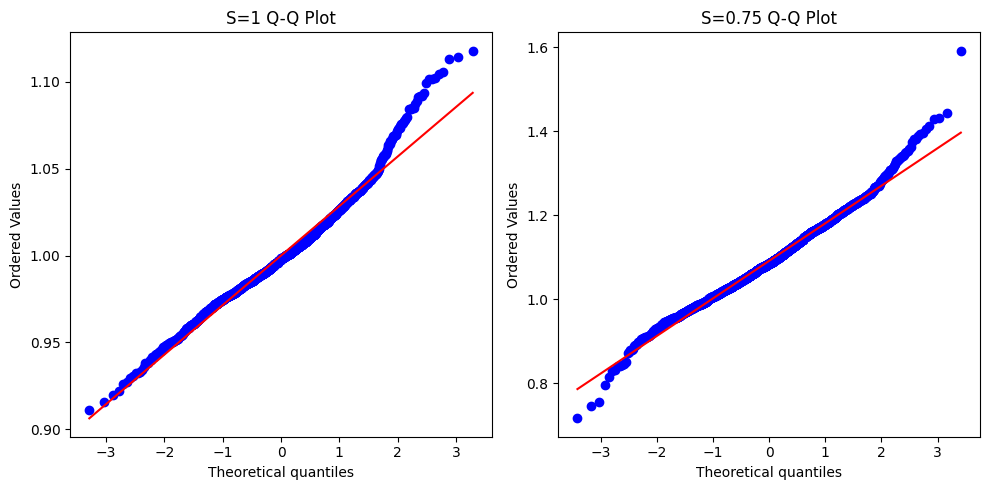

In [115]:
# Check for normality of the sample distributions before doing an F-test
# Shapiro-Wilk Test for normality
stat1, p1 = stats.shapiro(df[df.FrameSize == 'S=1'].NormalizedCellSize)
stat2, p2 = stats.shapiro(df[df.FrameSize == 'S=0.75'].NormalizedCellSize)

print(f"Sample 1: W={stat1:.3f}, p={p1:.3f}")
print(f"Sample 2: W={stat2:.3f}, p={p2:.3f}")

if p1 > 0.05 and p2 > 0.05:
    print("Both samples appear to be normally distributed.")
else:
    print("At least one sample does not appear to be normally distributed.")

# Q-Q Plot for visual inspection
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
stats.probplot(df[df.FrameSize == 'S=1'].NormalizedCellSize, dist="norm", plot=axes[0])
axes[0].set_title("S=1 Q-Q Plot")
stats.probplot(df[df.FrameSize == 'S=0.75'].NormalizedCellSize, dist="norm", plot=axes[1])
axes[1].set_title("S=0.75 Q-Q Plot")
plt.tight_layout()
plt.show()

In [116]:
# Levene Test to compare the variance of the cell size distributions of S=1 and S=0.75
# We do a Levene test and not an F-test because the normality assumption does not hold for the data
stat, p = stats.levene(df[df.FrameSize == 'S=1'].NormalizedCellSize, df[df.FrameSize == 'S=0.75'].NormalizedCellSize, center='mean')
print(f"Levene Test: W={stat:.3f}, p={p}")

Levene Test: W=971.173, p=1.269984621751304e-188


We find that the variance of `S=0.75` cells is significantly larger than `S=1` cells

In [117]:
#################### CANNOT USE THIS BECAUSE NORMALITY ASSUMPTION DOES NOT HOLD
# # F-test to compare the variances of 0.75 and reference cells
# var1 = df[df.FrameSize == 'S=0.75'].NormalizedCellSize.var()
# var2 = df[df.FrameSize == 'S=1'].NormalizedCellSize.var()

# F_stat = var1 / var2 if var1 > var2 else var2 / var1  # Ensure F >= 1 for one-tailed test

# # Degrees of freedom
# df1 = len(df[df.FrameSize == 'S=0.75'].NormalizedCellSize) - 1
# df2 = len(df[df.FrameSize == 'S=1'].NormalizedCellSize) - 1

# # Compute the p-value for a one-tailed test
# p_value = 1 - f.cdf(F_stat, df1, df2)

# print(f"F-statistic: {F_stat:.3f}")
# print(f"P-value: {p_value:.3f}")
# print(f"Degrees of Freedom: df1 = {df1}, df2 = {df2}")

### Using linear mixed models

In [118]:
# Create polars DataFrame for S=1 data
df_pl_1x = df[df.FrameSize == 'S=1']
df_pl_1x['Sample'] = df_pl_1x['Sample'].astype('category')
df_pl_1x['FrameSize'] = df_pl_1x['FrameSize'].astype('category')
df_pl_1x = pl.DataFrame(df_pl_1x)

/tmp/ipykernel_1330/1079906190.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pl_1x['Sample'] = df_pl_1x['Sample'].astype('category')
/tmp/ipykernel_1330/1079906190.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pl_1x['FrameSize'] = df_pl_1x['FrameSize'].astype('category')


In [119]:
# Fit the linear mixed model
model = lmer('NormalizedCellSize ~ 1 + (1|Sample)', data=df_pl_1x)
result = model.fit(summary=True)

# Extract the fixed effect
mu_hat = model.params.row(by_predicate=(pl.col('term') == '(Intercept)'))[1]
mu_ci_low = model.result_fit.row(by_predicate=(pl.col('term') == '(Intercept)'))[3]
mu_ci_high = model.result_fit.row(by_predicate=(pl.col('term') == '(Intercept)'))[4]
print(f'Estimated mean normalized cell size (S=1): {mu_hat:.3f} [{mu_ci_low:3f}, {mu_ci_high:3f}]')
result

Estimated mean normalized cell size (S=1): 1.010 [0.968860, 1.050878]


GT(_tbl_data=shape: (5, 10)
┌────────────────┬─────────────┬──────────┬───────────┬───┬───────────┬──────────┬─────────┬───────┐
│ rfx            ┆ param       ┆ estimate ┆ std_error ┆ … ┆ t_stat    ┆ df       ┆ p_value ┆ stars │
│ ---            ┆ ---         ┆ ---      ┆ ---       ┆   ┆ ---       ┆ ---      ┆ ---     ┆ ---   │
│ str            ┆ str         ┆ f64      ┆ f64       ┆   ┆ f64       ┆ f64      ┆ str     ┆ str   │
╞════════════════╪═════════════╪══════════╪═══════════╪═══╪═══════════╪══════════╪═════════╪═══════╡
│ Sample-sd      ┆ (Intercept) ┆ 0.025607 ┆ null      ┆ … ┆ null      ┆ null     ┆ null    ┆ null  │
│ Residual-sd    ┆ Observation ┆ 0.025455 ┆ null      ┆ … ┆ null      ┆ null     ┆ null    ┆ null  │
│ null           ┆ null        ┆ null     ┆ null      ┆ … ┆ null      ┆ null     ┆ null    ┆ null  │
│ Fixed Effects: ┆ null        ┆ null     ┆ null      ┆ … ┆ null      ┆ null     ┆ null    ┆ null  │
│ null           ┆ (Intercept) ┆ 1.009869 ┆ 0.012832  ┆ … ┆ 78.699908 ┆ 2.977925 ┆ <.001   ┆ ***   │
└────────────────┴─────────────┴──────────┴───────────┴───┴───────────┴──────────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x7feb4fb84d00>, _boxhead=Boxhead([ColInfo(var='rfx', type=<ColInfoTypeEnum.default: 1>, column_label='Random Effects:', column_align='left', column_width=None), ColInfo(var='param', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_label='CI-low', column_align='right', column_width=None), ColInfo(var='conf_high', type=<ColInfoTypeEnum.default: 1>, column_label='CI-high', column_align='right', column_width=None), ColInfo(var='t_stat', type=<ColInfoTypeEnum.default: 1>, column_label='T-stat', column_align='right', column_width=None), ColInfo(var='df', type=<ColInfoTypeEnum.default: 1>, column_label='DF', column_align='right', column_width=None), ColInfo(var='p_value', type=<ColInfoTypeEnum.default: 1>, column_label='p', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7feb4fb846a0>, _spanners=Spanners([]), _heading=Heading(title='Formula: lmer(NormalizedCellSize~1+(1|Sample))', subtitle=Md(text='Number of observations: *1364*  \n            Confidence intervals: *parametric*  \n            ---------------------  \n            Log-likelihood: *3057*  \n            AIC: *-6108* | BIC: *-6093*  \n            Residual error: *0.025*  \n        '), preheader=None), _stubhead=None, _source_notes=[Md(text='Signif. codes: *0 *** 0.001 ** 0.01 * 0.05 . 0.1*')], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns=['param'], rows=None, mask=None), grpname=None, colname='param', rownum=0, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=['param'], rows=None, mask=None), grpname=None, colname='param', rownum=1, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=['param'], rows=None, mask=None), grpname=None, colname='param', rownum=2, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=['param'], rows=None, mask=None), grpname=None, colname='param', rownum=3, colnum=

In [120]:
# Create polars DataFrame for S=0.75 data
df_pl_o75x = df[df.FrameSize == 'S=0.75']
df_pl_o75x['Sample'] = df_pl_o75x['Sample'] + 4
df_pl_o75x['Sample'] = df_pl_o75x['Sample'].astype('category')
df_pl_o75x['FrameSize'] = df_pl_o75x['FrameSize'].astype('category')
df_pl_o75x = pl.DataFrame(df_pl_o75x)

/tmp/ipykernel_1330/3137415675.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pl_o75x['Sample'] = df_pl_o75x['Sample'] + 4
/tmp/ipykernel_1330/3137415675.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pl_o75x['Sample'] = df_pl_o75x['Sample'].astype('category')
/tmp/ipykernel_1330/3137415675.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

In [121]:
# Fit the linear mixed model
model = lmer('NormalizedCellSize ~ 1 + (1|Sample)', data=df_pl_o75x)
result = model.fit(summary=True)

# Extract the fixed effect
mu_hat = model.params.row(by_predicate=(pl.col('term') == '(Intercept)'))[1]
mu_ci_low = model.result_fit.row(by_predicate=(pl.col('term') == '(Intercept)'))[3]
mu_ci_high = model.result_fit.row(by_predicate=(pl.col('term') == '(Intercept)'))[4]
print(f'Estimated mean normalized cell size (S=0.75): {mu_hat:.3f} [{mu_ci_low:3f}, {mu_ci_high:3f}]')
result

Estimated mean normalized cell size (S=0.75): 1.094 [1.050791, 1.138159]


GT(_tbl_data=shape: (5, 10)
┌────────────────┬─────────────┬──────────┬───────────┬───┬───────────┬──────────┬─────────┬───────┐
│ rfx            ┆ param       ┆ estimate ┆ std_error ┆ … ┆ t_stat    ┆ df       ┆ p_value ┆ stars │
│ ---            ┆ ---         ┆ ---      ┆ ---       ┆   ┆ ---       ┆ ---      ┆ ---     ┆ ---   │
│ str            ┆ str         ┆ f64      ┆ f64       ┆   ┆ f64       ┆ f64      ┆ str     ┆ str   │
╞════════════════╪═════════════╪══════════╪═══════════╪═══╪═══════════╪══════════╪═════════╪═══════╡
│ Sample-sd      ┆ (Intercept) ┆ 0.02707  ┆ null      ┆ … ┆ null      ┆ null     ┆ null    ┆ null  │
│ Residual-sd    ┆ Observation ┆ 0.08722  ┆ null      ┆ … ┆ null      ┆ null     ┆ null    ┆ null  │
│ null           ┆ null        ┆ null     ┆ null      ┆ … ┆ null      ┆ null     ┆ null    ┆ null  │
│ Fixed Effects: ┆ null        ┆ null     ┆ null      ┆ … ┆ null      ┆ null     ┆ null    ┆ null  │
│ null           ┆ (Intercept) ┆ 1.094475 ┆ 0.013684  ┆ … ┆ 79.982573 ┆ 2.983603 ┆ <.001   ┆ ***   │
└────────────────┴─────────────┴──────────┴───────────┴───┴───────────┴──────────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x7feb4fb5b5e0>, _boxhead=Boxhead([ColInfo(var='rfx', type=<ColInfoTypeEnum.default: 1>, column_label='Random Effects:', column_align='left', column_width=None), ColInfo(var='param', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_label='CI-low', column_align='right', column_width=None), ColInfo(var='conf_high', type=<ColInfoTypeEnum.default: 1>, column_label='CI-high', column_align='right', column_width=None), ColInfo(var='t_stat', type=<ColInfoTypeEnum.default: 1>, column_label='T-stat', column_align='right', column_width=None), ColInfo(var='df', type=<ColInfoTypeEnum.default: 1>, column_label='DF', column_align='right', column_width=None), ColInfo(var='p_value', type=<ColInfoTypeEnum.default: 1>, column_label='p', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7feb4fb5b970>, _spanners=Spanners([]), _heading=Heading(title='Formula: lmer(NormalizedCellSize~1+(1|Sample))', subtitle=Md(text='Number of observations: *2178*  \n            Confidence intervals: *parametric*  \n            ---------------------  \n            Log-likelihood: *2211*  \n            AIC: *-4417* | BIC: *-4400*  \n            Residual error: *0.087*  \n        '), preheader=None), _stubhead=None, _source_notes=[Md(text='Signif. codes: *0 *** 0.001 ** 0.01 * 0.05 . 0.1*')], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns=['param'], rows=None, mask=None), grpname=None, colname='param', rownum=0, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=['param'], rows=None, mask=None), grpname=None, colname='param', rownum=1, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=['param'], rows=None, mask=None), grpname=None, colname='param', rownum=2, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=['param'], rows=None, mask=None), grpname=None, colname='param', rownum=3, colnum=

In [122]:
# Fit model with size as fixed effect and random intercept per sample (compare the means using the slope coefficient from the mixed model)
model = lmer("NormalizedCellSize ~ FrameSize + (1|Sample)", data=pl.concat([df_pl_1x, df_pl_o75x]))
result = model.fit(summary=True)
result

sys:1: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance


GT(_tbl_data=shape: (6, 10)
┌──────────────┬──────────────┬──────────┬───────────┬───┬───────────┬──────────┬──────────┬───────┐
│ rfx          ┆ param        ┆ estimate ┆ std_error ┆ … ┆ t_stat    ┆ df       ┆ p_value  ┆ stars │
│ ---          ┆ ---          ┆ ---      ┆ ---       ┆   ┆ ---       ┆ ---      ┆ ---      ┆ ---   │
│ str          ┆ str          ┆ f64      ┆ f64       ┆   ┆ f64       ┆ f64      ┆ str      ┆ str   │
╞══════════════╪══════════════╪══════════╪═══════════╪═══╪═══════════╪══════════╪══════════╪═══════╡
│ Sample-sd    ┆ (Intercept)  ┆ 0.025974 ┆ null      ┆ … ┆ null      ┆ null     ┆ null     ┆ null  │
│ Residual-sd  ┆ Observation  ┆ 0.070208 ┆ null      ┆ … ┆ null      ┆ null     ┆ null     ┆ null  │
│ null         ┆ null         ┆ null     ┆ null      ┆ … ┆ null      ┆ null     ┆ null     ┆ null  │
│ Fixed        ┆ null         ┆ null     ┆ null      ┆ … ┆ null      ┆ null     ┆ null     ┆ null  │
│ Effects:     ┆              ┆          ┆           ┆   ┆           ┆          ┆          ┆       │
│ null         ┆ (Intercept)  ┆ 1.009414 ┆ 0.013196  ┆ … ┆ 76.492834 ┆ 5.948419 ┆ <.001    ┆ ***   │
│ null         ┆ FrameSizeS=0 ┆ 0.085072 ┆ 0.018586  ┆ … ┆ 4.577331  ┆ 5.854331 ┆ 0.004023 ┆ **    │
│              ┆ .75          ┆          ┆           ┆   ┆           ┆          ┆          ┆       │
└──────────────┴──────────────┴──────────┴───────────┴───┴───────────┴──────────┴──────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x7feb4fbaa800>, _boxhead=Boxhead([ColInfo(var='rfx', type=<ColInfoTypeEnum.default: 1>, column_label='Random Effects:', column_align='left', column_width=None), ColInfo(var='param', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_label='CI-low', column_align='right', column_width=None), ColInfo(var='conf_high', type=<ColInfoTypeEnum.default: 1>, column_label='CI-high', column_align='right', column_width=None), ColInfo(var='t_stat', type=<ColInfoTypeEnum.default: 1>, column_label='T-stat', column_align='right', column_width=None), ColInfo(var='df', type=<ColInfoTypeEnum.default: 1>, column_label='DF', column_align='right', column_width=None), ColInfo(var='p_value', type=<ColInfoTypeEnum.default: 1>, column_label='p', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7feb4fbaa200>, _spanners=Spanners([]), _heading=Heading(title='Formula: lmer(NormalizedCellSize~FrameSize+(1|Sample))', subtitle=Md(text='Number of observations: *3542*  \n            Confidence intervals: *parametric*  \n            ---------------------  \n            Log-likelihood: *4360*  \n            AIC: *-8713* | BIC: *-8689*  \n            Residual error: *0.07*  \n        '), preheader=None), _stubhead=None, _source_notes=[Md(text='Signif. codes: *0 *** 0.001 ** 0.01 * 0.05 . 0.1*')], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns=['param'], rows=None, mask=None), grpname=None, colname='param', rownum=0, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=['param'], rows=None, mask=None), grpname=None, colname='param', rownum=1, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=['param'], rows=None, mask=None), grpname=None, colname='param', rownu

The mean normalized cell size of `S=0.75` cells is significantly larger than the `S=1` cells, even after accounting for frame-level random effects within each construction mode

## Cell size trends

In [123]:
# Fitting a linear regression model
X = sm.add_constant(df[df.FrameSize.isin(['S=1', 'S=1.25', 'S=1.5', 'S=1.75', 'S=2'])]['FrameSize_x'])  # Add intercept
y = df[df.FrameSize.isin(['S=1', 'S=1.25', 'S=1.5', 'S=1.75', 'S=2'])]['NormalizedCellSize']
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     NormalizedCellSize   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                 9.039e+04
Date:                Thu, 05 Jun 2025   Prob (F-statistic):               0.00
Time:                        16:32:36   Log-Likelihood:                 5902.9
No. Observations:                5113   AIC:                        -1.180e+04
Df Residuals:                    5111   BIC:                        -1.179e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1140      0.004     25.604      

The model estimates a significant and positive trend between the printed cell size and the built cell size across different construction modes. For every one unit increase in the printed cell size, the built cell size of the honeycomb increases by 0.8874 in units.

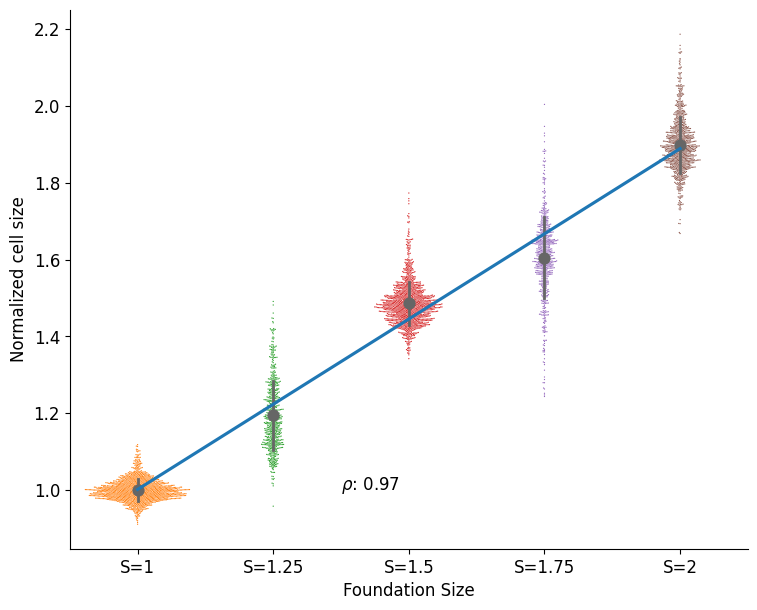

In [124]:
# Plot the cell size distributions for each construction mode as well as the estimated trend between the printed cell size and built cell size across construction modes
fig, axes = plt.subplots(figsize=(7*5/4,7))

corr, _ = pearsonr(df[df.FrameSize.isin(['S=1', 'S=1.25', 'S=1.5', 'S=1.75', 'S=2'])]['FrameSize_x'], df[df.FrameSize.isin(['S=1', 'S=1.25', 'S=1.5', 'S=1.75', 'S=2'])]['NormalizedCellSize'])

sns.swarmplot(data=df[df.FrameSize.isin(['S=1', 'S=1.25', 'S=1.5', 'S=1.75', 'S=2'])],
              x='FrameSize',
              y='NormalizedCellSize',
            #   alpha=0.5,
              order=['S=1', 'S=1.25', 'S=1.5', 'S=1.75', 'S=2'],
              palette=[color_dict[color] for color in ['S=1', 'S=1.25', 'S=1.5', 'S=1.75', 'S=2']],
              s=0.9,
              ax=axes,
              hue='FrameSize',
              zorder=0,
              )

df['FrameSize_num'] = df['FrameSize_num'] - 1
sns.regplot(df[df.FrameSize.isin(['S=1', 'S=1.25', 'S=1.5', 'S=1.75', 'S=2'])],
            x='FrameSize_num',
            y='NormalizedCellSize',
            scatter=False,
            ax=axes,
            )

plt.gca().lines[-1].set_zorder(3)  # Move the regression line to the top
df['FrameSize_num'] = df['FrameSize_num'] + 1

sns.pointplot(data=df[df.FrameSize.isin(['S=1', 'S=1.25', 'S=1.5', 'S=1.75', 'S=2'])],
              x='FrameSize',
              y='NormalizedCellSize',
              capsize=0,
              color='0.4',
              ax=axes,
              linestyles='',
              zorder=1,
              errorbar='sd',
              err_kws={'linewidth': 2},  # Error bar linewidth
              )

axes.text(1.5, 1, f'$\\rho$: {corr:.2f}', fontsize=12)

sns.despine()
axes.set_xlabel('Foundation Size', fontsize=12)
axes.set_ylabel('Normalized cell size', fontsize=12)

axes.tick_params(axis='both', which='major', labelsize=12)

fig.savefig('../output/figures/cell-size-trend-plot.png', dpi=600)

In [125]:
# Compute the correlation between the printed cell sizes and the built cell sizes
corr, p = pearsonr(df[df.FrameSize.isin(['S=1', 'S=1.25', 'S=1.5', 'S=1.75', 'S=2'])]['FrameSize_num'], df[df.FrameSize.isin(['S=1', 'S=1.25', 'S=1.5', 'S=1.75', 'S=2'])]['NormalizedCellSize'])
print(corr, p)

0.9728733658538725 0.0


In [126]:
# Print cell-size statistics for each construction mode
for framesize in df.FrameSize.unique():
    print(framesize)
    print(f'Normalized cell size: Mean = {df[df.FrameSize == framesize].NormalizedCellSize.mean()}, Std. dev. = {df[df.FrameSize == framesize].NormalizedCellSize.std()}')
    ci = sms.DescrStatsW(df[df.FrameSize == framesize].NormalizedCellSize).tconfint_mean()
    print(f"95% Confidence Interval: ({ci[0]:.2f}, {ci[1]:.2f})")
    print()

S=0.75
Normalized cell size: Mean = 1.0913982671681333, Std. dev. = 0.08974280418058236
95% Confidence Interval: (1.09, 1.10)

S=1
Normalized cell size: Mean = 0.9999999999999998, Std. dev. = 0.02883469562713418
95% Confidence Interval: (1.00, 1.00)

S=1.25
Normalized cell size: Mean = 1.194026800894303, Std. dev. = 0.08942685645310967
95% Confidence Interval: (1.19, 1.20)

S=1.5
Normalized cell size: Mean = 1.4860411683963524, Std. dev. = 0.05597788619328001
95% Confidence Interval: (1.48, 1.49)

S=1.75
Normalized cell size: Mean = 1.6046181626565446, Std. dev. = 0.10580035330870308
95% Confidence Interval: (1.60, 1.61)

S=2
Normalized cell size: Mean = 1.899031127462542, Std. dev. = 0.07271793573937727
95% Confidence Interval: (1.89, 1.90)

S=3
Normalized cell size: Mean = 0.9415986743272701, Std. dev. = 0.06411517041018393
95% Confidence Interval: (0.94, 0.95)



### Using linear mixed models

/tmp/ipykernel_1330/2694278538.py:5: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.swarmplot(data=df[df.FrameSize.isin([size])],
/tmp/ipykernel_1330/2694278538.py:5: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.swarmplot(data=df[df.FrameSize.isin([size])],
/tmp/ipykernel_1330/2694278538.py:5: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.swarmplot(data=df[df.FrameSize.isin([size])],
/tmp/ipykernel_1330/2694278538.py:5: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.swarmplot(data=df[df.FrameSize.isin([size])],
/tmp/ipykernel_1330/2694278538.py:5: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.swarmplot(data=df[df.FrameSize.isin([size])],


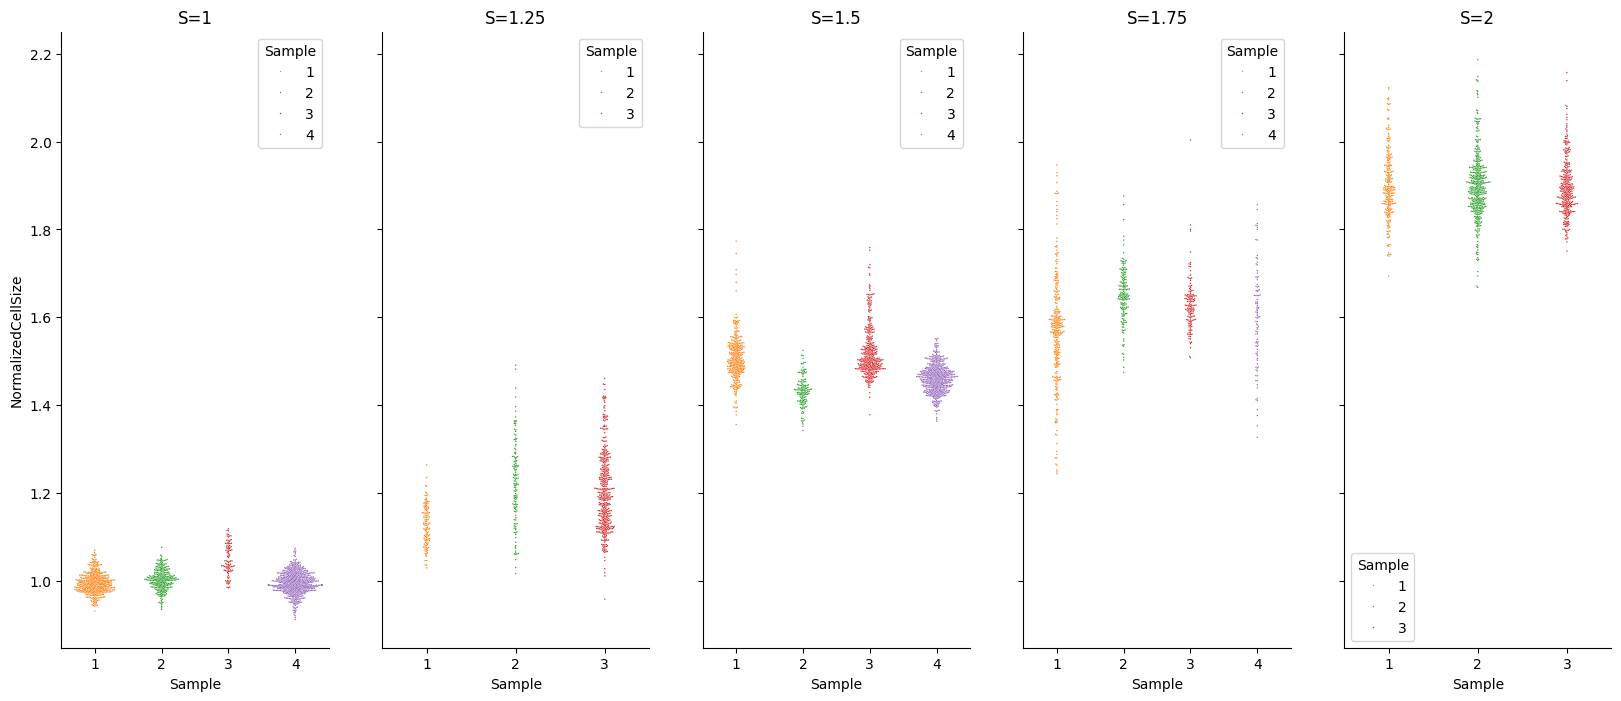

In [127]:
# Plot the built cell size distribution per replicate for each construction mode
fig, axes = plt.subplots(1, 5, figsize=(20, 8), sharey='row')

for i, size in enumerate(['S=1', 'S=1.25', 'S=1.5', 'S=1.75', 'S=2']):
    sns.swarmplot(data=df[df.FrameSize.isin([size])],
                x='Sample',
                y='NormalizedCellSize',
                palette=[color_dict[color] for color in ['S=1', 'S=1.25', 'S=1.5', 'S=1.75', 'S=2']],
                s=1,
                ax=axes[i],
                hue='Sample',
                zorder=0,
                )
    axes[i].set_title(size)

sns.despine()

fig.savefig('../output/figures/cell-size-distribution-by-sample.pdf')

In [128]:
# Create polars DataFrame for cell size data
df_cell_size_trend = df[df.FrameSize.isin(['S=1', 'S=1.25', 'S=1.5', 'S=1.75', 'S=2'])]

# Make all the sample numbers unique. Their actual value does not matter because this is converted to a categorical column
df_cell_size_trend.loc[df_cell_size_trend.FrameSize == 'S=1.25', 'Sample'] = df_cell_size_trend.loc[df_cell_size_trend.FrameSize == 'S=1.25', 'Sample'] + 10
df_cell_size_trend.loc[df_cell_size_trend.FrameSize == 'S=1.5', 'Sample'] = df_cell_size_trend.loc[df_cell_size_trend.FrameSize == 'S=1.5', 'Sample'] + 20
df_cell_size_trend.loc[df_cell_size_trend.FrameSize == 'S=1.75', 'Sample'] = df_cell_size_trend.loc[df_cell_size_trend.FrameSize == 'S=1.75', 'Sample'] + 30
df_cell_size_trend.loc[df_cell_size_trend.FrameSize == 'S=2', 'Sample'] = df_cell_size_trend.loc[df_cell_size_trend.FrameSize == 'S=2', 'Sample'] + 40

df_cell_size_trend['Sample'] = df_cell_size_trend['Sample'].astype('category')
df_cell_size_trend['FrameSize'] = df_cell_size_trend['FrameSize'].astype('category')
df_cell_size_trend = pl.DataFrame(df_cell_size_trend)

/tmp/ipykernel_1330/3746156306.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cell_size_trend['Sample'] = df_cell_size_trend['Sample'].astype('category')
/tmp/ipykernel_1330/3746156306.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cell_size_trend['FrameSize'] = df_cell_size_trend['FrameSize'].astype('category')


In [129]:
# Fit model with frame size as fixed effect and random intercept per sample (the trend is quantified by the slope coefficient in the mixed model)
model = lmer("NormalizedCellSize ~ FrameSize_x + (1|Sample)", data=df_cell_size_trend)
result = model.fit(summary=True)
result

GT(_tbl_data=shape: (6, 10)
┌───────────────┬─────────────┬──────────┬───────────┬───┬───────────┬───────────┬─────────┬───────┐
│ rfx           ┆ param       ┆ estimate ┆ std_error ┆ … ┆ t_stat    ┆ df        ┆ p_value ┆ stars │
│ ---           ┆ ---         ┆ ---      ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---     ┆ ---   │
│ str           ┆ str         ┆ f64      ┆ f64       ┆   ┆ f64       ┆ f64       ┆ str     ┆ str   │
╞═══════════════╪═════════════╪══════════╪═══════════╪═══╪═══════════╪═══════════╪═════════╪═══════╡
│ Sample-sd     ┆ (Intercept) ┆ 0.047815 ┆ null      ┆ … ┆ null      ┆ null      ┆ null    ┆ null  │
│ Residual-sd   ┆ Observation ┆ 0.064016 ┆ null      ┆ … ┆ null      ┆ null      ┆ null    ┆ null  │
│ null          ┆ null        ┆ null     ┆ null      ┆ … ┆ null      ┆ null      ┆ null    ┆ null  │
│ Fixed         ┆ null        ┆ null     ┆ null      ┆ … ┆ null      ┆ null      ┆ null    ┆ null  │
│ Effects:      ┆             ┆          ┆           ┆   ┆           ┆           ┆         ┆       │
│ null          ┆ (Intercept) ┆ 0.126449 ┆ 0.049585  ┆ … ┆ 2.550143  ┆ 15.94843  ┆ 0.02144 ┆ *     │
│ null          ┆ FrameSize_x ┆ 0.874278 ┆ 0.032483  ┆ … ┆ 26.915081 ┆ 15.943833 ┆ <.001   ┆ ***   │
└───────────────┴─────────────┴──────────┴───────────┴───┴───────────┴───────────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x7feb67cdcb20>, _boxhead=Boxhead([ColInfo(var='rfx', type=<ColInfoTypeEnum.default: 1>, column_label='Random Effects:', column_align='left', column_width=None), ColInfo(var='param', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_label='CI-low', column_align='right', column_width=None), ColInfo(var='conf_high', type=<ColInfoTypeEnum.default: 1>, column_label='CI-high', column_align='right', column_width=None), ColInfo(var='t_stat', type=<ColInfoTypeEnum.default: 1>, column_label='T-stat', column_align='right', column_width=None), ColInfo(var='df', type=<ColInfoTypeEnum.default: 1>, column_label='DF', column_align='right', column_width=None), ColInfo(var='p_value', type=<ColInfoTypeEnum.default: 1>, column_label='p', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7feb4df0f430>, _spanners=Spanners([]), _heading=Heading(title='Formula: lmer(NormalizedCellSize~FrameSize_x+(1|Sample))', subtitle=Md(text='Number of observations: *5113*  \n            Confidence intervals: *parametric*  \n            ---------------------  \n            Log-likelihood: *6749*  \n            AIC: *-13490* | BIC: *-13464*  \n            Residual error: *0.064*  \n        '), preheader=None), _stubhead=None, _source_notes=[Md(text='Signif. codes: *0 *** 0.001 ** 0.01 * 0.05 . 0.1*')], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns=['param'], rows=None, mask=None), grpname=None, colname='param', rownum=0, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=['param'], rows=None, mask=None), grpname=None, colname='param', rownum=1, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=['param'], rows=None, mask=None), grpname=None, colname='param', rownum=2, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=No

The cell size trend estimated by the mixed model (considering frame-level random effects within each construction mode) is consistent with the cell size trend previously estimated using the linear model.

## Angle trends

In [130]:
# Read angle data
angle_distribution_df = read_angle_data_from_dir('../input/angle-data').sort_values(['FrameSize', 'AngleOfTilt'])
drone_angle_df = pd.read_csv('../input/angle-data/natural_drone_cell_tilts.csv')
drone_angle_df['FrameSize'] = 'Drone'

In [131]:
# What are the number of samples in each construction modes?
angle_distribution_df.groupby(['FrameSize']).size()

FrameSize
S=1       24
S=1.25    18
S=1.5     16
S=1.75    16
S=2       14
dtype: int64

In [132]:
# 95% CI for mean angle of tilt for all foundations
for framesize in angle_distribution_df.FrameSize.unique():
    ci = sms.DescrStatsW(angle_distribution_df[angle_distribution_df.FrameSize == framesize].AngleOfTilt).tconfint_mean()
    print(f"{framesize}, Mean: {angle_distribution_df[angle_distribution_df.FrameSize == framesize].AngleOfTilt.mean():.2f}, Std. dev.: {angle_distribution_df[angle_distribution_df.FrameSize == framesize].AngleOfTilt.std():.2f}, 95% Confidence Interval: ({ci[0]:.2f}, {ci[1]:.2f})")

S=1, Mean: 8.74, Std. dev.: 2.34, 95% Confidence Interval: (7.75, 9.73)
S=1.25, Mean: 9.45, Std. dev.: 2.03, 95% Confidence Interval: (8.44, 10.46)
S=1.5, Mean: 22.64, Std. dev.: 0.86, 95% Confidence Interval: (22.18, 23.10)
S=1.75, Mean: 16.71, Std. dev.: 2.82, 95% Confidence Interval: (15.20, 18.21)
S=2, Mean: 27.10, Std. dev.: 1.72, 95% Confidence Interval: (26.10, 28.09)


In [133]:
# 95% CI for mean drone angle of tilt
ci = sms.DescrStatsW(drone_angle_df.AngleOfTilt).tconfint_mean()
print(f"Drone, Mean: {drone_angle_df.AngleOfTilt.mean():.2f}, Std. dev.: {drone_angle_df.AngleOfTilt.std():.2f}, 95% Confidence Interval: ({ci[0]:.2f}, {ci[1]:.2f})")

Drone, Mean: 20.00, Std. dev.: 2.43, 95% Confidence Interval: (18.86, 21.14)


In [134]:
# Fit a linear regression model to estimate the relationship between angle of tilt and the construction mode
X = sm.add_constant(angle_distribution_df['FrameSize_num'])  # Add intercept
y = angle_distribution_df['AngleOfTilt']
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            AngleOfTilt   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     204.0
Date:                Thu, 05 Jun 2025   Prob (F-statistic):           2.03e-24
Time:                        16:33:10   Log-Likelihood:                -247.66
No. Observations:                  88   AIC:                             499.3
Df Residuals:                      86   BIC:                             504.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             8.1839      0.687     11.908

0.8387145871760726 2.0345203525934884e-24


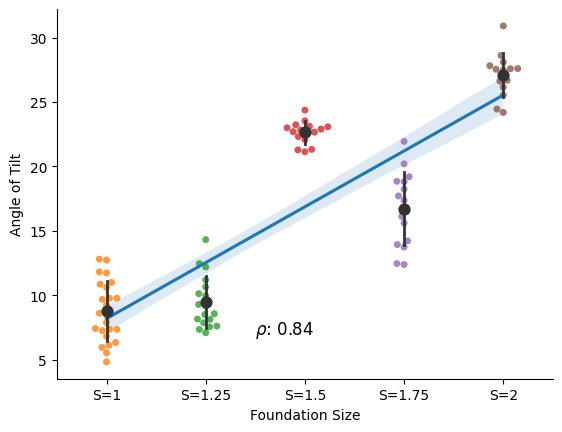

In [135]:
# Plot the distribution of angle of tilts against their construction mode along with a
# regression line estimating the trend of the angle of tilt against the construction mode
fig, axes = plt.subplots()

corr, p = pearsonr(angle_distribution_df['FrameSize_num'], angle_distribution_df['AngleOfTilt'])
print(corr, p)

sns.regplot(angle_distribution_df,
            x='FrameSize_num',
            y='AngleOfTilt',
            scatter=False,
            ax=axes,
            )
sns.swarmplot(data=angle_distribution_df,
              x='FrameSize',
              y='AngleOfTilt',
              alpha=0.8,
              order=['S=1', 'S=1.25', 'S=1.5', 'S=1.75', 'S=2'],
              palette=[color_dict[color] for color in ['S=1', 'S=1.25', 'S=1.5', 'S=1.75', 'S=2']],
            #   s=1,
              ax=axes,
              hue='FrameSize',
              zorder=1,
              )
sns.pointplot(data=angle_distribution_df,
              x='FrameSize',
              y='AngleOfTilt',
              capsize=0,
              color='0.2',
              errorbar='sd',
              ax=axes,
              linestyles='',
              zorder=2,
              err_kws={'linewidth': 2},
              )

axes.text(1.5, 7, f'$\\rho$: {corr:.2f}', fontsize=12)

axes.set_xlabel('Foundation Size')
axes.set_ylabel('Angle of Tilt')

sns.despine()

fig.savefig('../output/figures/angle-of-tilt-plot.png', dpi=600)

In [136]:
# One-tailed independent two-sample t-test for mean angle of 1.75 and 1.5
t_stat, p_value, dof = ttest_ind(angle_distribution_df[angle_distribution_df.FrameSize == 'S=1.75'].AngleOfTilt, angle_distribution_df[angle_distribution_df.FrameSize == 'S=1.5'].AngleOfTilt, alternative='smaller', usevar='unequal')
t_stat, p_value

(np.float64(-8.039904065668267), np.float64(1.2624938271220557e-07))

The mean angle of tilt for `S=1.5` cells is greater than that of `S=1.75` cells, showing that the positive trend in angle of tilt against construction mode is not strictly followed

Sample 1: W=0.966, p=0.769
Sample 2: W=0.941, p=0.356
Both samples appear to be normally distributed.


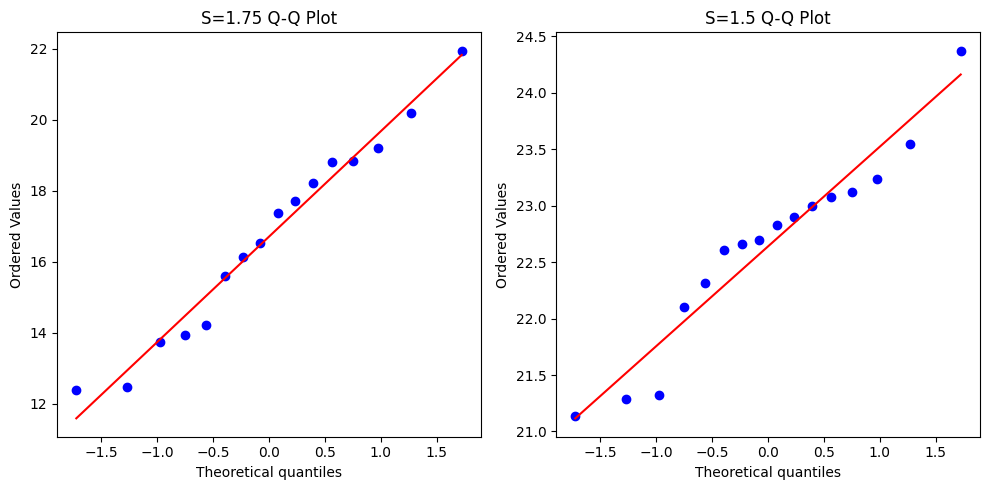

In [137]:
# Check for normality of the sample distributions before doing an F-test
# Shapiro-Wilk Test for normality
stat1, p1 = stats.shapiro(angle_distribution_df[angle_distribution_df.FrameSize == 'S=1.75'].AngleOfTilt)
stat2, p2 = stats.shapiro(angle_distribution_df[angle_distribution_df.FrameSize == 'S=1.5'].AngleOfTilt)

print(f"Sample 1: W={stat1:.3f}, p={p1:.3f}")
print(f"Sample 2: W={stat2:.3f}, p={p2:.3f}")

if p1 > 0.05 and p2 > 0.05:
    print("Both samples appear to be normally distributed.")
else:
    print("At least one sample does not appear to be normally distributed.")

# Q-Q Plot for visual inspection
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
stats.probplot(angle_distribution_df[angle_distribution_df.FrameSize == 'S=1.75'].AngleOfTilt, dist="norm", plot=axs[0])
axs[0].set_title("S=1.75 Q-Q Plot")
stats.probplot(angle_distribution_df[angle_distribution_df.FrameSize == 'S=1.5'].AngleOfTilt, dist="norm", plot=axs[1])
axs[1].set_title("S=1.5 Q-Q Plot")
plt.tight_layout()
plt.show()

In [138]:
# F-test to compare the variances of angle distribution of 1.75 and 1.5 cells (since both distributions pass normality test)
var1 = df[df.FrameSize == 'S=1.75'].NormalizedCellSize.var()
var2 = df[df.FrameSize == 'S=1.5'].NormalizedCellSize.var()

F_stat = var1 / var2 if var1 > var2 else var2 / var1

# Degrees of freedom
df1 = len(df[df.FrameSize == 'S=1.75'].NormalizedCellSize) - 1
df2 = len(df[df.FrameSize == 'S=1.5'].NormalizedCellSize) - 1

# Compute the p-value for a one-tailed test
p_value = 1 - f.cdf(F_stat, df1, df2)

print(f"F-statistic: {F_stat:.3f}")
print(f"P-value: {p_value:.3f}")
print(f"Degrees of Freedom: df1 = {df1}, df2 = {df2}")

F-statistic: 3.572
P-value: 0.000
Degrees of Freedom: df1 = 705, df2 = 1368


The variance of the angle of tilt distribution of `S=1.75` cells is significantly greater than that of `S=1.5` cells. We cannot use linear mixed models to estimate the trend, taking into consideration frame-level random effects within each construction mode, because we have only one replicate per construction mode in our angle data.

## 1x vs 3x cell sizes

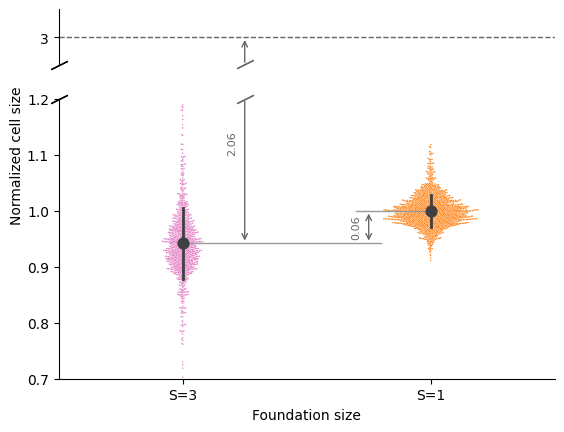

In [139]:
# Plot the cell size distributions and Mean + std. dev.
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [0.1, 0.5]})

# Set the y-axis limits to break the axis
ax1.set_ylim(2.95, 3.05)  # Focus on the higher value
ax2.set_ylim(0.7, 1.2)    # Focus on the lower values

# Hide the spines between the two subplots
ax1.spines.bottom.set_visible(False)
ax1.spines.top.set_visible(False)
ax1.spines.right.set_visible(False)
ax2.spines.top.set_visible(False)
ax2.spines.right.set_visible(False)

ax1.tick_params(bottom=False, labelbottom=False)  # Hide x-axis labels for the top plot
ax1.set_yticks([3])
ax2.tick_params(top=False)  # Remove ticks on top plot

# Add diagonal lines to indicate the break
d = .5
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mew=1, clip_on=False)
ax1.plot([0, 0], [0, 0], transform=ax1.transAxes, **kwargs, mec='0.0')
ax2.plot([0, 0], [1, 1], transform=ax2.transAxes, **kwargs, mec='0.0')

# Add diagonal lines for break in the doublearrow
ax1.plot([0.375, 0.375], [0.02, 0.02], transform=ax1.transAxes, **kwargs, mec='0.4')
ax2.plot([0.375, 0.375], [1, 1], transform=ax2.transAxes, **kwargs, mec='0.4')

sns.swarmplot(data=pd.concat([df[df.FrameSize == 'S=3'], df[df.FrameSize == 'S=1']]),
              x='FrameSize',
              y='NormalizedCellSize',
              order=['S=3', 'S=1'],
              palette=[color_dict[color] for color in ['S=3', 'S=1']],
              s=1,
              ax=ax2,
              hue='FrameSize',
              legend=True,
              )
sns.pointplot(data=df[df.FrameSize.isin(['S=3', 'S=1'])],
              x='FrameSize',
              y='NormalizedCellSize',
              capsize=0,
              color='0.25',
              ax=ax2,
              linestyles='',
              zorder=20,
              errorbar='sd',
              err_kws={'linewidth': 2},
              )

ymean_3 = df[df.FrameSize == 'S=3']['NormalizedCellSize'].mean()
ymean_1 = df[df.FrameSize == 'S=1']['NormalizedCellSize'].mean()

ax1.axhline(y=3, linestyle='dashed', linewidth=1, color='0.4', zorder=0) # Line to show S=3 in the plot
ax2.axhline(y=ymean_3, xmin=0.25, xmax=0.65, linestyle='-', linewidth=1, color='0.6', zorder=10) # Line to show the mean of S=3 built cells
ax2.axhline(y=ymean_1, xmin=0.6, xmax=0.75, linestyle='-', linewidth=1, color='0.6', zorder=10) # Line to show the mean of S=1 built cells

# Bidirectional arrow to indicate the difference between the mean normalized cell size for S=1 and S=3 built cells
ax2.annotate(
    '',
    xy=(0.75, ymean_3),
    xytext=(0.75, ymean_1),
    arrowprops=dict(arrowstyle='<->', color='0.4', lw=1),  # Bidirectional arrow
    ha='center',
    va='center',
)

# Add text for the difference
ax2.text(
    x=0.7,
    y=(ymean_3 + ymean_1) / 2,  # Place the text midway between the lines
    s=f'{abs(ymean_3-ymean_1):.2f}', 
    ha='center', 
    va='center', 
    fontsize=8, 
    color='0.4',
    rotation='vertical',
)

# Broken bidirectional arrow to indicate the difference between the mean normalized cell size for S=1 and S=3 built cells
ax2.annotate(
    '',
    xy=(0.25, ymean_3),
    xytext=(0.25, 1.2),
    arrowprops=dict(arrowstyle='->', color='0.4', lw=1),  # Unidirectional arrow
    ha='center',
    va='center',
)
ax1.annotate(
    '',
    xy=(0.25, 2.95),
    xytext=(0.25, 3),
    arrowprops=dict(arrowstyle='<-', color='0.4', lw=1),  # Unidirectional arrow
    ha='center',
    va='center',
)

# Add text for the difference
ax2.text(
    x=0.2,
    y=(ymean_3 + 1.3) / 2,  # Place the text midway between the lines
    s=f'{abs(ymean_3-3):.2f}', 
    ha='center', 
    va='center', 
    fontsize=8, 
    color='0.4',
    rotation='vertical',
)

ax2.set_ylabel('Normalized cell size')
ax2.yaxis.set_label_coords(-0.07, 0.8)
ax2.set_xlabel('Foundation size')

ax2.get_legend().remove()

fig.savefig('../output/figures/3-vs-1-cell-size.png', dpi=600)

### Mean normalized cell size per replicate and all data pooled

#### S=1

In [140]:
print(f'Normalized cell size distribution on reference frames: Mean = {df[df.FrameSize == "S=1"].NormalizedCellSize.mean()}, Std. dev. = {df[df.FrameSize == "S=1"].NormalizedCellSize.std()}')
print(f'Cell size distribution on reference frames: Mean = {df[df.FrameSize == "S=1"].area_mm2.mean()}, Std. dev. = {df[df.FrameSize == "S=1"].area_mm2.std()}')
ci = sms.DescrStatsW(df[df.FrameSize == "S=1"].area_mm2).tconfint_mean()
print(f"95% Confidence Interval: ({ci[0]:.2f}, {ci[1]:.2f})")

Normalized cell size distribution on reference frames: Mean = 0.9999999999999998, Std. dev. = 0.02883469562713418
Cell size distribution on reference frames: Mean = 12.956534931308967, Std. dev. = 0.37359774112662586
95% Confidence Interval: (12.94, 12.98)


#### S=3

In [141]:
for i in sorted(df[df.FrameSize == 'S=3'].Sample.unique()):
    print(f'Technical replicate {i}:')

    # print cell size stats for replicates
    print(f'Normalized cell size distribution on S=3 frames: Mean = {df[(df.FrameSize == "S=3") & (df.Sample == i)].NormalizedCellSize.mean()}, Std. dev. = {df[(df.FrameSize == "S=3") & (df.Sample == i)].NormalizedCellSize.std()}')
    print(f'Cell size distribution on S=3 frames: Mean = {df[(df.FrameSize == "S=3") & (df.Sample == i)].area_mm2.mean()}, Std. dev. = {df[(df.FrameSize == "S=3") & (df.Sample == i)].area_mm2.std()}')
    ci = sms.DescrStatsW(df[(df.FrameSize == "S=3") & (df.Sample == i)].area_mm2).tconfint_mean()
    print(f"95% Confidence Interval: ({ci[0]:.2f}, {ci[1]:.2f})")
    print()

# print pooled cell size stats
print(f'Normalized cell size distribution on S=3 frames: Mean = {df[df.FrameSize == "S=3"].NormalizedCellSize.mean()}, Std. dev. = {df[df.FrameSize == "S=3"].NormalizedCellSize.std()}')
print(f'Cell size distribution on S=3 frames: Mean = {df[df.FrameSize == "S=3"].area_mm2.mean()}, Std. dev. = {df[df.FrameSize == "S=3"].area_mm2.std()}')
ci = sms.DescrStatsW(df[df.FrameSize == "S=3"].area_mm2).tconfint_mean()
print(f"95% Confidence Interval: ({ci[0]:.2f}, {ci[1]:.2f})")

Technical replicate 1:
Normalized cell size distribution on S=3 frames: Mean = 0.9327351011440612, Std. dev. = 0.06303525244991953
Cell size distribution on S=3 frames: Mean = 12.085014919631032, Std. dev. = 0.8167184502712614
95% Confidence Interval: (12.02, 12.15)

Technical replicate 2:
Normalized cell size distribution on S=3 frames: Mean = 0.93638738597887, Std. dev. = 0.04752259906132567
Cell size distribution on S=3 frames: Mean = 12.132335875672325, Std. dev. = 0.6157282147646567
95% Confidence Interval: (11.99, 12.28)

Technical replicate 3:
Normalized cell size distribution on S=3 frames: Mean = 0.956192647373616, Std. dev. = 0.06607328201774833
Cell size distribution on S=3 frames: Mean = 12.388943436757053, Std. dev. = 0.8560807864891848
95% Confidence Interval: (12.30, 12.48)

Normalized cell size distribution on S=3 frames: Mean = 0.9415986743272701, Std. dev. = 0.06411517041018393
Cell size distribution on S=3 frames: Mean = 12.199856115195493, Std. dev. = 0.830710445046

### Compare the mean and variance of the normalized cell sizes for S=3 and S=1

In [142]:
# One-tailed two-sample t-test for means of 0.75 and reference cells
t_stat, p_value, dof = ttest_ind(df[df.FrameSize == 'S=3'].NormalizedCellSize, df[df.FrameSize == 1].NormalizedCellSize, alternative='smaller', usevar='unequal')
t_stat, p_value

/home/chethan749/.virtualenvs/peleg/lib/python3.10/site-packages/statsmodels/stats/weightstats.py:135: RuntimeWarning: invalid value encountered in scalar divide
  return self.sum / self.sum_weights
/home/chethan749/.virtualenvs/peleg/lib/python3.10/site-packages/statsmodels/stats/weightstats.py:190: RuntimeWarning: invalid value encountered in scalar divide
  return self.sumsquares / self.sum_weights


(np.float64(nan), np.float64(nan))

The mean normalized cell size of `S=3` cells is larger than that of `S=1` cells

Sample 1: W=0.975, p=0.000
Sample 2: W=0.940, p=0.000
At least one sample does not appear to be normally distributed.


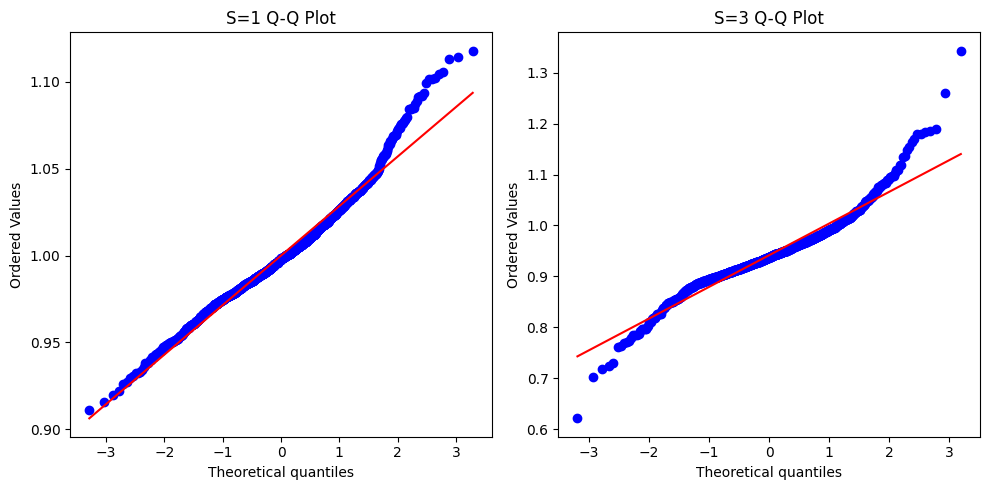

In [143]:
# Check for normality of the sample distributions before doing an F-test
# Shapiro-Wilk Test for normality
stat1, p1 = stats.shapiro(df[df.FrameSize == 'S=1'].NormalizedCellSize)
stat2, p2 = stats.shapiro(df[df.FrameSize == 'S=3'].NormalizedCellSize)

print(f"Sample 1: W={stat1:.3f}, p={p1:.3f}")
print(f"Sample 2: W={stat2:.3f}, p={p2:.3f}")

if p1 > 0.05 and p2 > 0.05:
    print("Both samples appear to be normally distributed.")
else:
    print("At least one sample does not appear to be normally distributed.")

# Q-Q Plot for visual inspection
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
stats.probplot(df[df.FrameSize == 'S=1'].NormalizedCellSize, dist="norm", plot=axs[0])
axs[0].set_title("S=1 Q-Q Plot")
stats.probplot(df[df.FrameSize == 'S=3'].NormalizedCellSize, dist="norm", plot=axs[1])
axs[1].set_title("S=3 Q-Q Plot")
plt.tight_layout()
plt.show()

In [144]:
# Levene Test to compare variances
stat, p = stats.levene(df[df.FrameSize == 'S=1'].NormalizedCellSize, df[df.FrameSize == 'S=3'].NormalizedCellSize, center='mean')
print(f"Levene Test: W={stat:.3f}, p={p}")

Levene Test: W=285.590, p=1.5103534514566237e-60


We find that the variance of `S=3` cells is significantly larger than `S=1` cells

In [145]:
#################### CANNOT USE THIS BECAUSE NORMALITY ASSUMPTION DOES NOT HOLD
# # F-test to compare the variances of 0.75 and reference cells
# var1 = df[df.FrameSize == 'S=3'].NormalizedCellSize.var()
# var2 = df[df.FrameSize == 'S=1'].NormalizedCellSize.var()

# F_stat = var1 / var2 if var1 > var2 else var2 / var1  # Ensure F >= 1 for one-tailed test

# # Degrees of freedom
# df1 = len(df[df.FrameSize == 'S=3'].NormalizedCellSize) - 1
# df2 = len(df[df.FrameSize == 'S=1'].NormalizedCellSize) - 1

# # Compute the p-value for a one-tailed test
# p_value = 1 - f.cdf(F_stat, df1, df2)

# print(f"F-statistic: {F_stat:.3f}")
# print(f"P-value: {p_value:.3f}")
# print(f"Degrees of Freedom: df1 = {df1}, df2 = {df2}")

### Using linear mixture models

In [146]:
# Fit the linear mixed model
model = lmer('NormalizedCellSize ~ 1 + (1|Sample)', data=df_pl_1x)
result = model.fit(summary=True)

# Extract the fixed effect
mu_hat = model.params.row(by_predicate=(pl.col('term') == '(Intercept)'))[1]
mu_ci_low = model.result_fit.row(by_predicate=(pl.col('term') == '(Intercept)'))[3]
mu_ci_high = model.result_fit.row(by_predicate=(pl.col('term') == '(Intercept)'))[4]
print(f'Estimated mean normalized cell size (S=1): {mu_hat:.3f} [{mu_ci_low:3f}, {mu_ci_high:3f}]')
result

Estimated mean normalized cell size (S=1): 1.010 [0.968860, 1.050878]


GT(_tbl_data=shape: (5, 10)
┌────────────────┬─────────────┬──────────┬───────────┬───┬───────────┬──────────┬─────────┬───────┐
│ rfx            ┆ param       ┆ estimate ┆ std_error ┆ … ┆ t_stat    ┆ df       ┆ p_value ┆ stars │
│ ---            ┆ ---         ┆ ---      ┆ ---       ┆   ┆ ---       ┆ ---      ┆ ---     ┆ ---   │
│ str            ┆ str         ┆ f64      ┆ f64       ┆   ┆ f64       ┆ f64      ┆ str     ┆ str   │
╞════════════════╪═════════════╪══════════╪═══════════╪═══╪═══════════╪══════════╪═════════╪═══════╡
│ Sample-sd      ┆ (Intercept) ┆ 0.025607 ┆ null      ┆ … ┆ null      ┆ null     ┆ null    ┆ null  │
│ Residual-sd    ┆ Observation ┆ 0.025455 ┆ null      ┆ … ┆ null      ┆ null     ┆ null    ┆ null  │
│ null           ┆ null        ┆ null     ┆ null      ┆ … ┆ null      ┆ null     ┆ null    ┆ null  │
│ Fixed Effects: ┆ null        ┆ null     ┆ null      ┆ … ┆ null      ┆ null     ┆ null    ┆ null  │
│ null           ┆ (Intercept) ┆ 1.009869 ┆ 0.012832  ┆ … ┆ 78.699908 ┆ 2.977925 ┆ <.001   ┆ ***   │
└────────────────┴─────────────┴──────────┴───────────┴───┴───────────┴──────────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x7feb4f81e590>, _boxhead=Boxhead([ColInfo(var='rfx', type=<ColInfoTypeEnum.default: 1>, column_label='Random Effects:', column_align='left', column_width=None), ColInfo(var='param', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_label='CI-low', column_align='right', column_width=None), ColInfo(var='conf_high', type=<ColInfoTypeEnum.default: 1>, column_label='CI-high', column_align='right', column_width=None), ColInfo(var='t_stat', type=<ColInfoTypeEnum.default: 1>, column_label='T-stat', column_align='right', column_width=None), ColInfo(var='df', type=<ColInfoTypeEnum.default: 1>, column_label='DF', column_align='right', column_width=None), ColInfo(var='p_value', type=<ColInfoTypeEnum.default: 1>, column_label='p', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7feb40bdd870>, _spanners=Spanners([]), _heading=Heading(title='Formula: lmer(NormalizedCellSize~1+(1|Sample))', subtitle=Md(text='Number of observations: *1364*  \n            Confidence intervals: *parametric*  \n            ---------------------  \n            Log-likelihood: *3057*  \n            AIC: *-6108* | BIC: *-6093*  \n            Residual error: *0.025*  \n        '), preheader=None), _stubhead=None, _source_notes=[Md(text='Signif. codes: *0 *** 0.001 ** 0.01 * 0.05 . 0.1*')], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns=['param'], rows=None, mask=None), grpname=None, colname='param', rownum=0, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=['param'], rows=None, mask=None), grpname=None, colname='param', rownum=1, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=['param'], rows=None, mask=None), grpname=None, colname='param', rownum=2, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=['param'], rows=None, mask=None), grpname=None, colname='param', rownum=3, colnum=

In [147]:
# Create polars DataFrame for S=3 data
df_pl_3x = df[df.FrameSize == 'S=3']
df_pl_3x['Sample'] = df_pl_3x['Sample'] + 4
df_pl_3x['Sample'] = df_pl_3x['Sample'].astype('category')
df_pl_3x['FrameSize'] = df_pl_3x['FrameSize'].astype('category')
df_pl_3x = pl.DataFrame(df_pl_3x)

/tmp/ipykernel_1330/2469795484.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pl_3x['Sample'] = df_pl_3x['Sample'] + 4
/tmp/ipykernel_1330/2469795484.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pl_3x['Sample'] = df_pl_3x['Sample'].astype('category')
/tmp/ipykernel_1330/2469795484.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

In [148]:
# Fit the linear mixed model
model = lmer('NormalizedCellSize ~ 1 + (1|Sample)', data=df_pl_3x)
result = model.fit(summary=True)

# Extract the fixed effect
mu_hat = model.params.row(by_predicate=(pl.col('term') == '(Intercept)'))[1]
mu_ci_low = model.result_fit.row(by_predicate=(pl.col('term') == '(Intercept)'))[3]
mu_ci_high = model.result_fit.row(by_predicate=(pl.col('term') == '(Intercept)'))[4]
print(f'Estimated mean normalized cell size (S=3): {mu_hat:.3f} [{mu_ci_low:3f}, {mu_ci_high:3f}]')
result

Estimated mean normalized cell size (S=3): 0.942 [0.911251, 0.972956]


GT(_tbl_data=shape: (5, 10)
┌───────────────┬─────────────┬──────────┬───────────┬───┬────────────┬──────────┬─────────┬───────┐
│ rfx           ┆ param       ┆ estimate ┆ std_error ┆ … ┆ t_stat     ┆ df       ┆ p_value ┆ stars │
│ ---           ┆ ---         ┆ ---      ┆ ---       ┆   ┆ ---        ┆ ---      ┆ ---     ┆ ---   │
│ str           ┆ str         ┆ f64      ┆ f64       ┆   ┆ f64        ┆ f64      ┆ str     ┆ str   │
╞═══════════════╪═════════════╪══════════╪═══════════╪═══╪════════════╪══════════╪═════════╪═══════╡
│ Sample-sd     ┆ (Intercept) ┆ 0.012482 ┆ null      ┆ … ┆ null       ┆ null     ┆ null    ┆ null  │
│ Residual-sd   ┆ Observation ┆ 0.063199 ┆ null      ┆ … ┆ null       ┆ null     ┆ null    ┆ null  │
│ null          ┆ null        ┆ null     ┆ null      ┆ … ┆ null       ┆ null     ┆ null    ┆ null  │
│ Fixed         ┆ null        ┆ null     ┆ null      ┆ … ┆ null       ┆ null     ┆ null    ┆ null  │
│ Effects:      ┆             ┆          ┆           ┆   ┆            ┆          ┆         ┆       │
│ null          ┆ (Intercept) ┆ 0.942104 ┆ 0.007706  ┆ … ┆ 122.258701 ┆ 2.164637 ┆ <.001   ┆ ***   │
└───────────────┴─────────────┴──────────┴───────────┴───┴────────────┴──────────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x7feb40bf1c60>, _boxhead=Boxhead([ColInfo(var='rfx', type=<ColInfoTypeEnum.default: 1>, column_label='Random Effects:', column_align='left', column_width=None), ColInfo(var='param', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_label='CI-low', column_align='right', column_width=None), ColInfo(var='conf_high', type=<ColInfoTypeEnum.default: 1>, column_label='CI-high', column_align='right', column_width=None), ColInfo(var='t_stat', type=<ColInfoTypeEnum.default: 1>, column_label='T-stat', column_align='right', column_width=None), ColInfo(var='df', type=<ColInfoTypeEnum.default: 1>, column_label='DF', column_align='right', column_width=None), ColInfo(var='p_value', type=<ColInfoTypeEnum.default: 1>, column_label='p', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7feb40bdfc10>, _spanners=Spanners([]), _heading=Heading(title='Formula: lmer(NormalizedCellSize~1+(1|Sample))', subtitle=Md(text='Number of observations: *982*  \n            Confidence intervals: *parametric*  \n            ---------------------  \n            Log-likelihood: *1311*  \n            AIC: *-2616* | BIC: *-2601*  \n            Residual error: *0.063*  \n        '), preheader=None), _stubhead=None, _source_notes=[Md(text='Signif. codes: *0 *** 0.001 ** 0.01 * 0.05 . 0.1*')], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns=['param'], rows=None, mask=None), grpname=None, colname='param', rownum=0, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=['param'], rows=None, mask=None), grpname=None, colname='param', rownum=1, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=['param'], rows=None, mask=None), grpname=None, colname='param', rownum=2, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locnam

In [149]:
# Fit model with size as fixed effect and random intercept per sample (compare the means using the slope coefficient from the mixed model)
model = lmer("NormalizedCellSize ~ FrameSize + (1|Sample)", data=pl.concat([df_pl_1x, df_pl_3x]))
result = model.fit(summary=True)
result

sys:1: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance


GT(_tbl_data=shape: (6, 10)
┌──────────────┬─────────────┬───────────┬───────────┬───┬───────────┬──────────┬──────────┬───────┐
│ rfx          ┆ param       ┆ estimate  ┆ std_error ┆ … ┆ t_stat    ┆ df       ┆ p_value  ┆ stars │
│ ---          ┆ ---         ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---      ┆ ---      ┆ ---   │
│ str          ┆ str         ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64      ┆ str      ┆ str   │
╞══════════════╪═════════════╪═══════════╪═══════════╪═══╪═══════════╪══════════╪══════════╪═══════╡
│ Sample-sd    ┆ (Intercept) ┆ 0.021006  ┆ null      ┆ … ┆ null      ┆ null     ┆ null     ┆ null  │
│ Residual-sd  ┆ Observation ┆ 0.045263  ┆ null      ┆ … ┆ null      ┆ null     ┆ null     ┆ null  │
│ null         ┆ null        ┆ null      ┆ null      ┆ … ┆ null      ┆ null     ┆ null     ┆ null  │
│ Fixed        ┆ null        ┆ null      ┆ null      ┆ … ┆ null      ┆ null     ┆ null     ┆ null  │
│ Effects:     ┆             ┆           ┆           ┆   ┆           ┆          ┆          ┆       │
│ null         ┆ (Intercept) ┆ 1.0096    ┆ 0.010612  ┆ … ┆ 95.139436 ┆ 4.859267 ┆ <.001    ┆ ***   │
│ null         ┆ FrameSizeS= ┆ -0.067752 ┆ 0.016244  ┆ … ┆ -4.170996 ┆ 4.897943 ┆ 0.009127 ┆ **    │
│              ┆ 3           ┆           ┆           ┆   ┆           ┆          ┆          ┆       │
└──────────────┴─────────────┴───────────┴───────────┴───┴───────────┴──────────┴──────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x7feb40bf01f0>, _boxhead=Boxhead([ColInfo(var='rfx', type=<ColInfoTypeEnum.default: 1>, column_label='Random Effects:', column_align='left', column_width=None), ColInfo(var='param', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_label='CI-low', column_align='right', column_width=None), ColInfo(var='conf_high', type=<ColInfoTypeEnum.default: 1>, column_label='CI-high', column_align='right', column_width=None), ColInfo(var='t_stat', type=<ColInfoTypeEnum.default: 1>, column_label='T-stat', column_align='right', column_width=None), ColInfo(var='df', type=<ColInfoTypeEnum.default: 1>, column_label='DF', column_align='right', column_width=None), ColInfo(var='p_value', type=<ColInfoTypeEnum.default: 1>, column_label='p', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7feb40bf1960>, _spanners=Spanners([]), _heading=Heading(title='Formula: lmer(NormalizedCellSize~FrameSize+(1|Sample))', subtitle=Md(text='Number of observations: *2346*  \n            Confidence intervals: *parametric*  \n            ---------------------  \n            Log-likelihood: *3912*  \n            AIC: *-7816* | BIC: *-7793*  \n            Residual error: *0.045*  \n        '), preheader=None), _stubhead=None, _source_notes=[Md(text='Signif. codes: *0 *** 0.001 ** 0.01 * 0.05 . 0.1*')], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns=['param'], rows=None, mask=None), grpname=None, colname='param', rownum=0, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=['param'], rows=None, mask=None), grpname=None, colname='param', rownum=1, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=['param'], rows=None, mask=None), grpname=None, colname='param', rown

The mean normalized cell size of `S=3` cells is significantly smaller than the `S=1` cells, even after accounting for frame-level random effects within each construction mode